# Complex Modulus fitting

To execute a cell, press `Shift+Enter`

v2.2
 - Fit permittivity as well as conductivities

v2.1
 - Added `data_format` parameter to specify input file type
 - Read excel files for Dan

In [1]:
# Import modules used
import json # Export fit parameters
import numpy as np # Efficient array handling
import pandas as pd
from scipy.optimize import least_squares # Fitting
import modulus_fitting_functions as fit # Other functions
import  matplotlib.pyplot as plt # Plotting
%matplotlib notebook
e0 = 8.854188e-14 #F/cm (vacuum permittivity)
p = {} # Initialize dictonary to hold everything

<IPython.core.display.Javascript object>


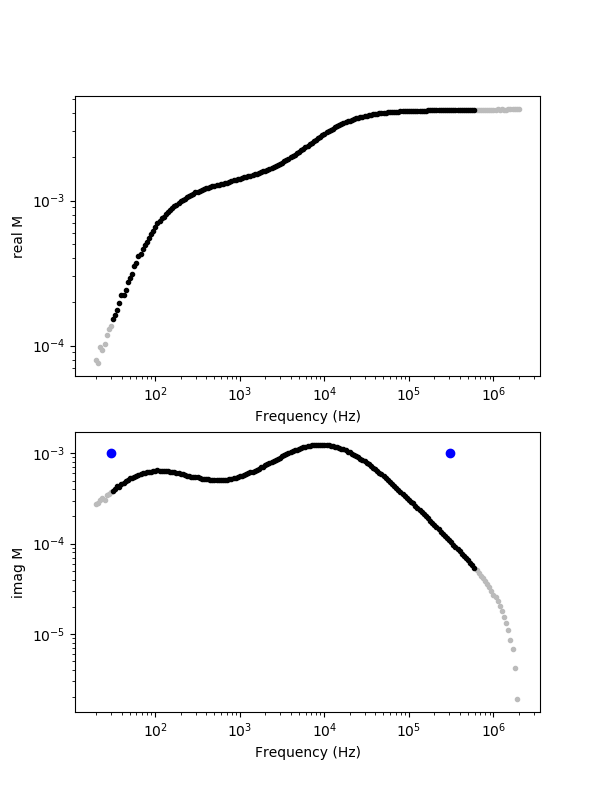

In [11]:
##########################################################
#####  Change these values  ##############################

p['filename'] = 'data.csv' # Name of file
p['data_format'] = 'PSU' # 'PSU' or 'NCSU' to read respective file types
p['slices'] = 30 # Number of slices
p['freq_lo'] = 30.0 # Lowest frequency fitting window
p['freq_hi'] = 6e5 # Highest frequency fitting window
p['permittivity'] = -1.0 # Best guess of permittivity, set to < 0 for a guess from high frequency data
p['eps_lo'] = 200.0 # Lowest allowed permittivity
p['eps_hi'] = 250.0 # Highest allowed permittivity
p['sigma_lo'] = 4e-9 # Lowest allowed conductivity
p['sigma_hi'] = 4e-5 # Highest allowed conductivity
p['bins'] = 10 # Bins for histogram

########################################################
########################################################

p['data'] = fit.read_modulus_data(p)
p['mask'] = np.where((p['data'][:,0] >= p['freq_lo']) & (p['data'][:,0] <= p['freq_hi']))
p['sel_data'] = p['data'][p['mask']]
p['inv_mask'] = np.where((p['data'][:,0] < p['freq_lo']) | (p['data'][:,0] > p['freq_hi']))
p['inv_data'] = p['data'][p['inv_mask']]
if p['permittivity'] < 0:
    p['permittivity'] = 1.0 / np.max(p['sel_data'][:,1])
p['bounded_eps'] = fit.real_to_bounded(p['permittivity'], p['eps_lo'], p['eps_hi'])
p['log_sigmas'] = np.linspace(np.log10(p['sigma_lo'])+0.1, np.log10(p['sigma_hi'])-0.1, p['slices'])
p['bounded_sigmas'] = fit.real_to_bounded(p['log_sigmas'], np.log10(p['sigma_lo']), np.log10(p['sigma_hi']))
p['bounded_inputs'] = np.concatenate((np.array([p['bounded_eps']]), p['bounded_sigmas']))
p['inputs_lo'] = np.concatenate((np.array([p['eps_lo']]), np.array([p['sigma_lo']] * p['slices'])))
p['inputs_hi'] = np.concatenate((np.array([p['eps_hi']]), np.array([p['sigma_hi']] * p['slices'])))
fig = fit.plot_modulus(p)

`ftol` termination condition is satisfied.
Function evaluations 40, initial cost 1.6473e-03, final cost 1.6473e-03, first-order optimality 1.08e-07.


<IPython.core.display.Javascript object>


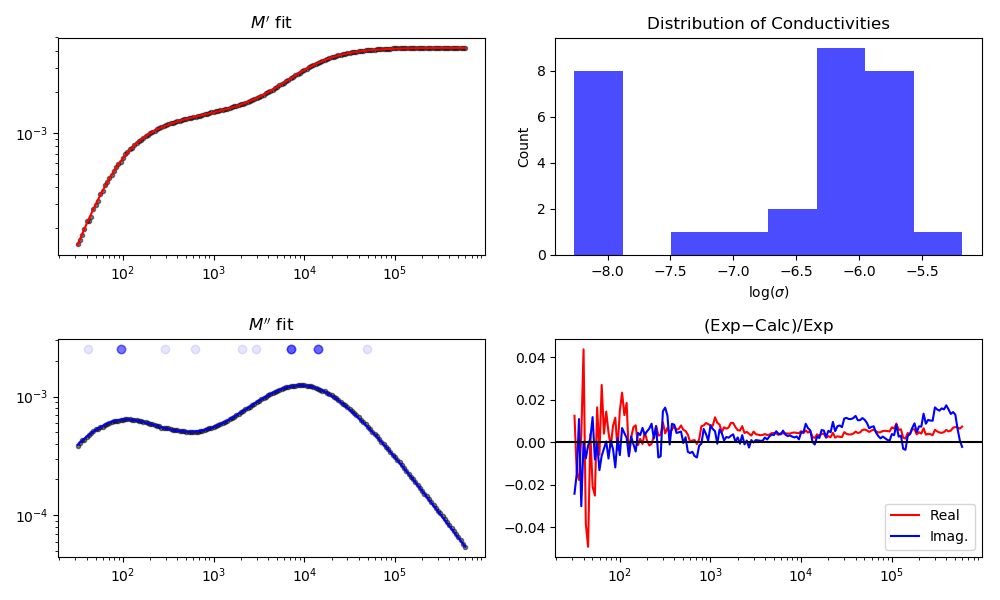

In [15]:
# Parameters for least_squares function
params = {
    'fun': fit.fit_eps_sigmas_residual, # Function to fit
    'x0': p['bounded_inputs'], # Initial values to be optimized
    'args': (p['inputs_lo'], p['inputs_hi'], p['sel_data']), # Additional arguments (not optimized)
    'max_nfev': 1000000, # Max number of iterations
    'method': 'lm',
    'verbose': 1 # How much output to print
}
# Fit the data
res = least_squares(**params)
p['bounded_inputs'] = res['x']
p['bounded_eps'] = res['x'][0]
p['permittivity'] = fit.bounded_to_real(p['bounded_eps'], p['eps_lo'], p['eps_hi'])
p['bounded_sigmas'] = res['x'][1:]
p['log_sigmas'] = fit.bounded_to_real(p['bounded_sigmas'], np.log10(p['sigma_lo']), np.log10(p['sigma_hi']))
p['best_fit'] = fit.complex_modulus(10**p['log_sigmas'], p['sel_data'][:,0], p['permittivity'])
p['real_residual'] = (p['sel_data'][:,1]-p['best_fit'][:,1])/p['sel_data'][:,1]
p['imag_residual'] = (p['sel_data'][:,2]-p['best_fit'][:,2])/p['sel_data'][:,2]
fig2 = fit.plot_result(p)
plt.tight_layout()

For more information on the `least_squares` function, [follow this link](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.optimize.least_squares.html)

In [10]:
##############
# Change the suffix to avoid overwriting files
suffix = "_1"
##############

export_modulus = np.concatenate((p['sel_data'], p['best_fit'][:,1:],
                                 p['real_residual'][:,np.newaxis], p['imag_residual'][:,np.newaxis]),
                                axis=-1)
np.savetxt(p['filename'][:-4]+'_modulus'+suffix+'.txt', export_modulus, delimiter='\t',
          header='freq.\tRealM\tImagM\tRealMCalc\tImagMCalc\tRealResidual\tImagResidual')

export_sigmas = np.column_stack((p['log_sigmas'], 10**p['log_sigmas'], 10**p['log_sigmas']/(2*np.pi*p['permittivity']*e0)))

np.savetxt(p['filename'][:-4]+'_sigmas'+suffix+'.txt', export_sigmas, delimiter='\t',
          header='logSigma\tSigma\tfr')

export_dict = {k:p[k] for k in ('freq_lo', 'slices', 'sigma_lo', 'bins', 'freq_hi', 'sigma_hi', 'permittivity', 'filename')}
# Fit parameters set by the user
with open(p['filename'][:-4]+'_fitparams'+suffix+'.txt', 'w') as outfile:
    json.dump(export_dict, outfile, sort_keys=True, indent=0, separators=(',',': '))

In [9]:
p['permittivity']

238.5777599695758

In [14]:
p['bins'] = 8